# Hackathon

Some utilities

## Import Utils

In [16]:
!pip install keras
!pip install tables

You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [33]:
import keras
from keras.metrics import top_k_categorical_accuracy
import h5py as h5
import numpy as np
import pandas as pd
import tables

PATH_DATA = '/notebooks/data/equi_Groupe6.h5'
PATH_PREDICT_WITHOUT_GT = '/notebooks/data/pred_students/pred_from_half/pred_eighties_from_half_1_without_gt.h5'
PATH_SUBMIT = '/notebooks/ChallengeHacka/pred_eighties_from_half_1_gr6.csv'
# PATH_PREDICT_WITH_GT = '/pred_teachers/pred_eighties_from_half_1.h5'

In [34]:
BATCH_SIZE = 32
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout
import keras.layers.normalization 
from keras.callbacks import Callback
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
def get_idxs(h5_path):
    f = h5.File(h5_path)
    return range(len(f['S2']))

def shuffle_idx(sample_idxs):
    return list(np.random.permutation(sample_idxs))

def split_train_val(sample_idxs, proportion):
    n_samples = len(sample_idxs)
    return sample_idxs[:int((1.-proportion)*n_samples)], sample_idxs[int((1.-proportion)*n_samples):]

def get_batch_count(idxs, batch_size):
    batch_count = int(len(idxs)//batch_size)
    remained_samples = len(idxs)%batch_size
    if remained_samples > 0:
        batch_count += 1

    return batch_count

In [36]:
def generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')
    while True : 
        idxs = shuffle_idx(idxs)
        batch_count = get_batch_count(idxs, batch_size)
        for b in range(batch_count):
            batch_idx = idxs[b*batch_size]
            X = f['S2'][batch_idx:batch_idx+batch_size, :,:,:]
            Y = f['TOP_LANDCOVER'][batch_idx:batch_idx+batch_size, :]
            yield np.array(X), keras.utils.np_utils.to_categorical(np.array(Y), 23)

In [37]:
idxs = get_idxs(PATH_DATA)
shuffled_idxs = shuffle_idx(idxs)
train_idxs, val_idxs = split_train_val(shuffled_idxs, 0.2)

print(len(idxs))

53606


In [38]:
train_gen = generator(PATH_DATA, BATCH_SIZE, train_idxs)
train_batch_count = get_batch_count(train_idxs, BATCH_SIZE)

val_gen = generator(PATH_DATA, BATCH_SIZE, val_idxs)
val_batch_count = get_batch_count(val_idxs, BATCH_SIZE)

In [39]:
print(train_batch_count, val_batch_count)

1341 336


In [40]:
label = h5.File(PATH_DATA)['TOP_LANDCOVER']
images = h5.File(PATH_DATA)['S2']

In [45]:
counts = np.zeros(23)
lbl = np.zeros(len(label))

for idx, value in enumerate(label):
    counts[int(value)] += 1
    lbl[idx] = value

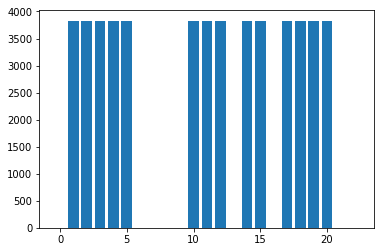

In [46]:
import matplotlib.pyplot as plt

plt.bar(np.arange(len(counts)), counts)
plt.show()

In [47]:
pd_lbl = pd.DataFrame(lbl)
pd_lbl.head()

,0
0,20.0
1,20.0
2,20.0
3,20.0
4,20.0


In [48]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

# Instanciation du model

In [54]:
input_shape = (16,16,4)

dropout_rate=0.5

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(23, activation='softmax'))

# Fit

In [55]:
# optim = keras.optimizers.Adam(lr=0.001)
optim = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

model.compile(optimizer=optim,
              loss='categorical_crossentropy',
              metrics=['accuracy', top_3_accuracy, top_5_accuracy ])

history = model.fit_generator(train_gen, steps_per_epoch=train_batch_count, epochs=10, verbose=1, validation_data=val_gen, nb_val_samples=1000)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1341, epochs=10, verbose=1, validation_data=<generator..., validation_steps=1000)`
  


Epoch 1/10
1341/1341 [==============================] - 34s 25ms/step - loss: 3.4855 - acc: 0.0758 - top_3_accuracy: 0.2197 - top_5_accuracy: 0.3554 - val_loss: 2.8571 - val_acc: 0.1089 - val_top_3_accuracy: 0.2641 - val_top_5_accuracy: 0.4033
Epoch 2/10
1341/1341 [==============================] - 33s 24ms/step - loss: 2.9945 - acc: 0.0972 - top_3_accuracy: 0.2718 - top_5_accuracy: 0.4261 - val_loss: 2.8367 - val_acc: 0.0970 - val_top_3_accuracy: 0.3132 - val_top_5_accuracy: 0.4503
Epoch 3/10
1341/1341 [==============================] - 33s 24ms/step - loss: 2.6816 - acc: 0.1435 - top_3_accuracy: 0.3526 - top_5_accuracy: 0.5158 - val_loss: 3.1044 - val_acc: 0.0740 - val_top_3_accuracy: 0.2535 - val_top_5_accuracy: 0.4142
Epoch 4/10
1341/1341 [==============================] - 33s 25ms/step - loss: 2.4689 - acc: 0.1950 - top_3_accuracy: 0.4253 - top_5_accuracy: 0.5945 - val_loss: 3.2579 - val_acc: 0.0613 - val_top_3_accuracy: 0.2157 - val_top_5_accuracy: 0.3647
Epoch 5/10
1341/1341 [==

## Prediction routines

In order to submit a result here are some gits

In [59]:
import os 
def prediction_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        X = f['S2'][batch_idxs, :,:,:]
        yield np.array(X)

# def build_h5_pred_file(pred, h5_output_path):
#     if os.path.exists(h5_output_path):
#         os.remove(h5_output_path)
#     f = h5.File(h5_output_path, 'w')
#     top_landcover_submit = f.create_dataset("TOP_LANDCOVER", (len(pred), 1), maxshape=(None, 1))equi
#     top_landcover_submit[:, 0] = pred
#     f.close()
#     4
#     return 1

In [60]:
prediction = model.predict_generator(val_gen, steps=val_batch_count, verbose=1)
print(len(prediction))
#to dataframe to csv index = ID colonne TOP_LANDCOVER

336/336 [==============================] - 4s 13ms/step
10752


In [ ]:
pred_idx = get_idxs(PATH_PREDICT_WITHOUT_GT)
print(len(pred_idx))
pred_gen = prediction_generator(PATH_PREDICT_WITHOUT_GT, BATCH_SIZE, pred_idx)
prediction = model.predict_generator(pred_gen, steps=get_batch_count(pred_idx, BATCH_SIZE), verbose=1)
print(len(prediction))
# build_h5_pred_file(np.argmax(prediction, axis = 1), PATH_SUBMIT)
panda_prediction = pd.DataFrame(np.argmax(prediction, axis = 1))
panda_prediction.columns = ['TOP_LANDCOVER']
panda_prediction.head()
# panda_prediction.describe()
panda_prediction.to_csv(PATH_SUBMIT, index_label = 'ID')

241700
1486/7554 [====>.........................] - ETA: 20s

## Some ideas for monitoring

In [ ]:
def gt_generator(h5_path, batch_size, idxs):
    f = h5.File(h5_path, 'r')

    batch_count = get_batch_count(idxs, batch_size)
    
    for b in range(batch_count):
        batch_idxs = idxs[b*batch_size:(b+1)*batch_size]
        batch_idxs = sorted(batch_idxs)
        Y = f['TOP_LANDCOVER'][batch_idxs, :]
        yield keras.utils.np_utils.to_categorical(np.array(Y), 23)

gt_gen = gt_generator(PATH_PREDICT_WITH_GT, BATCH_SIZE, pred_idx)
gt = []
for elem in gt_gen:
    gt.append(elem)
gt = np.vstack(gt)

In [ ]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",fontsize=7)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def clean_confusion_matrix(confusion_matrix, classes):
    real_classes = []
    for c in range(len(classes)):
        if np.sum(confusion_matrix[:,c])+np.sum(confusion_matrix[c, :]) != 0:
            real_classes.append(c)
    real_confusion_matrix = np.empty((len(real_classes), len(real_classes)))  
    for c_index in range(len(real_classes)):
        real_confusion_matrix[c_index,:] = confusion_matrix[real_classes[c_index], real_classes]
    return real_confusion_matrix, real_classes

In [ ]:
%matplotlib notebook
from sklearn.metrics import confusion_matrix
y_true = np.argmax(gt, axis=1)
y_pred = np.argmax(prediction, axis = 1)

real_cnf_matrix, real_classes = clean_confusion_matrix(confusion_matrix(y_true, y_pred, labels= range(23)), range(23))
plot_confusion_matrix(real_cnf_matrix, classes = real_classes, normalize=True)